## 9장 로지스틱 회귀 모델(다중 클래스 분류)

In [83]:
import numpy as np
import matplotlib.pyplot as plt

### Prepare dataset

In [84]:
# 학습용 데이터 준비
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org = iris.data, iris.target

# 입력 데이터에 관해서는 sepal length(0)와 petal length(2)만을 추출
x_select = x_org[:,[0,2]]
print(f'original_data {x_select.shape, y_org.shape}')

original_data ((150, 2), (150,))


### Display scatter plot of dataset

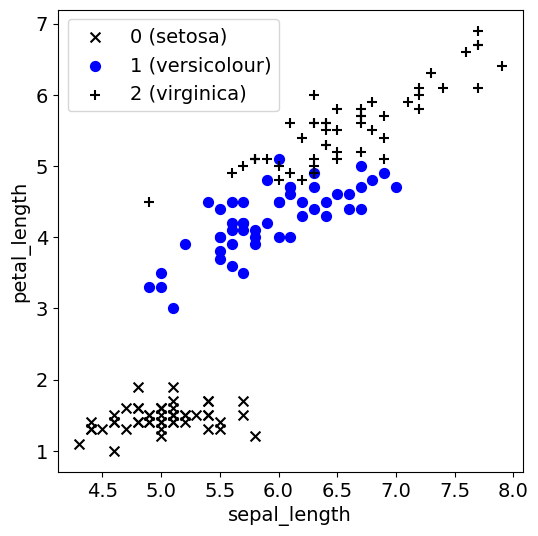

In [85]:
# 산점도 표시
x_t0 = x_select[y_org == 0]
x_t1 = x_select[y_org == 1]
x_t2 = x_select[y_org == 2]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('petal_length', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()

### Data Preprocessing

In [86]:
# 더미 변수를 추가
x_all = np.insert(x_select, 0, 1.0, axis=1)

#### **one-hot-coding**
- 원핫 인코딩(One-Hot Encoding)은 **범주형 데이터를 수치형 데이터로 변환하는 방법 중 하나**입니다. 주로 머신 러닝 및 자연어 처리 분야에서 사용되며, 각 범주에 대해 이진 값의 열을 만들어 해당 범주에 속하는지 여부를 나타냅니다.

- 원핫 인코딩은 범주형 데이터를 다룰 때 사용되는 인코딩 방법입니다. 각각의 범주를 이진 형태로 표현하여 범주에 속하는지 여부를 나타냅니다. 원핫 인코딩은 다음과 같은 단계로 이루어집니다

1. **고유한 범주 확인**: 인코딩할 데이터에서 고유한 범주를 확인합니다. 예를 들어, "사과", "바나나", "오렌지"와 같은 과일이라는 범주가 있다고 가정해봅시다.

2. **인코딩할 열 생성**: 각각의 고유한 범주에 대해 이진 값의 열을 생성합니다. 이 열은 해당 범주에 속하는지 여부를 나타냅니다. 위의 예시에서는 "과일"이라는 열을 생성할 수 있습니다.

3. **인코딩 값 할당**: 각 행에 대해 해당하는 범주에 1을 할당하고, 나머지 열에는 0을 할당합니다. 예를 들어, "사과"에 해당하는 행의 "과일" 열은 1로, "바나나"와 "오렌지"에 해당하는 행의 "과일" 열은 0으로 표시됩니다.

4. **장점**: 원핫 인코딩은 범주형 데이터를 수치형 데이터로 변환하는 간단하고 직관적인 방법입니다. 머신 러닝 알고리즘에 적용하기 쉽고, 각 범주에 대한 정보를 보존합니다.

5. **주의 사항**: 원핫 인코딩은 범주의 개수에 따라 새로운 열이 생성되므로, 범주가 많은 경우 데이터의 차원이 증가할 수 있습니다. 또한, 인코딩된 데이터는 범주 간의 순서나 관계를 나타내지 않습니다.

In [87]:
# y의 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, categories='auto')
y_work = np.c_[y_org]
# Translates slice objects to concatenation along the second axis

y_all_one = ohe.fit_transform(y_work)
print('오리지널', y_org.shape)
print('2차원화', y_work.shape)
print('원핫 인코딩', y_all_one.shape)

오리지널 (150,)
2차원화 (150, 1)
원핫 인코딩 (150, 3)


In [88]:
# 학습 데이터와 검증 데이터를 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(
    x_all, y_org, y_all_one, train_size=75, test_size=75, random_state=2023)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, 
    y_train_one.shape, y_test_one.shape)

(75, 3) (75, 3) (75,) (75,) (75, 3) (75, 3)


In [89]:
print('입력 데이터(x)')
print(x_train[:5,:])

입력 데이터(x)
[[1.  6.9 5.4]
 [1.  5.6 4.5]
 [1.  5.  1.6]
 [1.  5.  3.3]
 [1.  6.2 4.3]]


In [90]:
print('정답값(y)')
print(y_train[:5])

정답값(y)
[2 1 0 1 1]


In [91]:
print('정답값(원핫 인코딩)')
print(y_train_one[:5])

정답값(원핫 인코딩)
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


### Setting variables for training

In [92]:
# 학습 대상의 선택
x, yt = x_train, y_train_one # x(feature), yt(label)

### Predict function

In [93]:
# 소프트맥스 함수
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T

In [94]:
# 예측값 계산
def pred(x, W):
    return softmax(x @ W)

### Evaluation

In [95]:
# 교차 엔트로피 함수
# -1이 붙는 이유 : 경사하강법의 손실함수는 값을 최소화하는 것이
# 목적이므로 가능도함수에 -1을 곱해서 손실함수로 사용
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

In [96]:
# 모델을 평가하는 함수
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_one, W):
    
    # 예측값 계산(확률값)
    yp_test_one = pred(x_test, W)
    
    # 확률값에서 예측 클래스(0, 1, 2)를 도출 (1, 0, 0), (0, 1, 0), (0, 0, 1)
    yp_test = np.argmax(yp_test_one, axis=1)
    
    # 손실함수 값 계산
    loss = cross_entropy(y_test_one, yp_test_one)
    
    # 정확도 산출
    score = accuracy_score(y_test, yp_test)
    return loss, score

### Initialization

In [97]:
# 초기화 처리

# 표본 수
M = x.shape[0]
# 입력 차원 수(더미 변수를 포함)
D = x.shape[1]
# 분류 대상 클래스 수
N = yt.shape[1]

# 반복 횟수
iters = 10000

# 학습률
alpha = 0.01

# 가중치 행렬의 초기 설정(모두가 1)
W = np.ones((D, N)) 

# 평가 결과 기록
history = np.zeros((0, 3))

### Main

In [98]:
# 주요 처리
for k in range(10000):
    
    # 예측값 계산
    yp = pred(x, W)
    
    # 오차 계산
    yd = yp - yt

    # 가중치 업데이트
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history,
            np.array([k, loss, score])))
        print(f"epoch = {k} loss = {loss} score = {score}")

epoch = 0 loss = 1.094158166961351 score = 0.26666666666666666
epoch = 10 loss = 1.0807833735402699 score = 0.26666666666666666
epoch = 20 loss = 1.05125701147785 score = 0.26666666666666666
epoch = 30 loss = 1.0204833996585272 score = 0.3333333333333333
epoch = 40 loss = 0.9918218824397322 score = 0.5733333333333334
epoch = 50 loss = 0.9653466970776211 score = 0.5866666666666667
epoch = 60 loss = 0.9408757566284881 score = 0.6
epoch = 70 loss = 0.9182324127373545 score = 0.6
epoch = 80 loss = 0.8972555586746648 score = 0.6
epoch = 90 loss = 0.8777970846339209 score = 0.6
epoch = 100 loss = 0.8597208650921683 score = 0.6
epoch = 110 loss = 0.8429023203631181 score = 0.6
epoch = 120 loss = 0.8272279587397119 score = 0.6
epoch = 130 loss = 0.8125947854381962 score = 0.6
epoch = 140 loss = 0.7989096046129767 score = 0.6
epoch = 150 loss = 0.7860882633003166 score = 0.6
epoch = 160 loss = 0.7740548792420792 score = 0.6
epoch = 170 loss = 0.7627410828853456 score = 0.6
epoch = 180 loss = 0.

### Result

In [99]:
# 손실함수의 값과 정확도 점검
print(f"[초기 상태] 손실함수: {history[0,1]}, 정확도 : {history[0,2]}")
print(f"[최종 상태] 손실함수: {history[-1,1]}, 정확도 : {history[-1,2]}")

[초기 상태] 손실함수: 1.094158166961351, 정확도 : 0.26666666666666666
[최종 상태] 손실함수: 0.20075497638580825, 정확도 : 0.9466666666666667


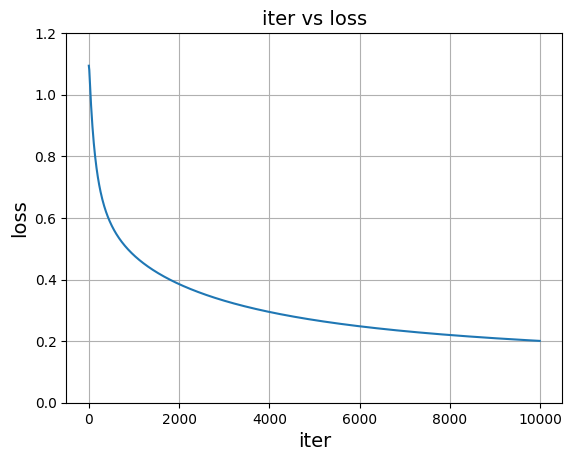

In [100]:
# 학습 곡선 표시 (손실 함수)
plt.plot(history[:,0], history[:,1])
plt.grid()
plt.ylim(0,1.2)
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

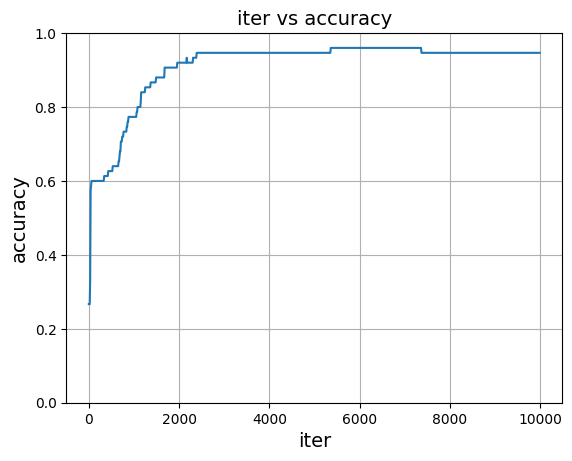

In [101]:
# 학습 곡선 표시 (정밀도)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

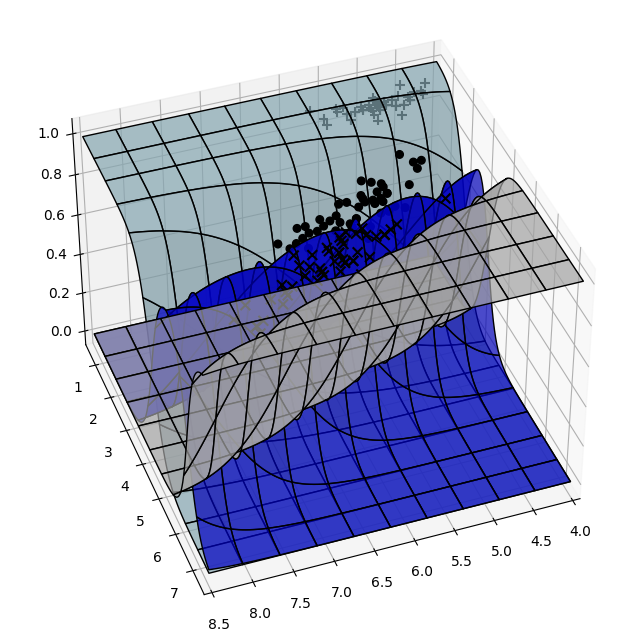

In [102]:
# 3차원 표시
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 8.5, 100)
x2 = np.linspace(0.5, 7.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.array([np.ones(xx1.ravel().shape), 
    xx1.ravel(), xx2.ravel()]).T
pp = pred(xxx, W)
c0 = pp[:,0].reshape(xx1.shape)
c1 = pp[:,1].reshape(xx1.shape)
c2 = pp[:,2].reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c0, color='lightblue', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c1, color='blue', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c2, color='lightgrey', 
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.scatter(x_t0[:,0], x_t0[:,1], 1, s=50, alpha=1, marker='+', c='k')
ax.scatter(x_t1[:,0], x_t1[:,1], 1, s=30, alpha=1, marker='o', c='k')
ax.scatter(x_t2[:,0], x_t2[:,1], 1, s=50, alpha=1, marker='x', c='k')
ax.set_xlim(4,8.5)
ax.set_ylim(0.5,7.5)
ax.view_init(elev=40, azim=70)

In [103]:
# 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 테스트 데이터로 예측값 계산
yp_test_one = pred(x_test, W)
yp_test = np.argmax(yp_test_one, axis=1)

# 정확도 계산
score = accuracy_score(y_test, yp_test)
print(f'accuracy: {score}')

# 컨퓨전 매트릭스의 표시
print(confusion_matrix(y_test, yp_test))
print(classification_report(y_test, yp_test))

accuracy: 0.9466666666666667
[[25  0  0]
 [ 0 28  2]
 [ 0  2 18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       0.93      0.93      0.93        30
           2       0.90      0.90      0.90        20

    accuracy                           0.95        75
   macro avg       0.94      0.94      0.94        75
weighted avg       0.95      0.95      0.95        75



### 입력 변수를 4차원으로 변경

In [104]:
# 더미 변수를 추가
x_all2 = np.insert(x_org, 0, 1.0, axis=1)

In [105]:
# 학습 데이터와 검증 데이터로 분할
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train, y_test,\
y_train_one, y_test_one = train_test_split(
    x_all2, y_org, y_all_one, train_size=75, 
    test_size=75, random_state=123)
print(x_train2.shape, x_test2.shape, 
    y_train.shape, y_test.shape, 
    y_train_one.shape, y_test_one.shape)

(75, 5) (75, 5) (75,) (75,) (75, 3) (75, 3)


In [106]:
print(f"입력 데이터(x) : \n {x_train2[:5]}")

입력 데이터(x) : 
 [[1.  6.3 3.3 4.7 1.6]
 [1.  7.  3.2 4.7 1.4]
 [1.  5.  3.  1.6 0.2]
 [1.  6.4 2.8 5.6 2.1]
 [1.  6.3 2.5 5.  1.9]]


In [107]:
# 학습 데이터
x, yt, x_test = x_train2, y_train_one, x_test2

In [108]:
# 초기화 처리

# 표본 수
M = x.shape[0]
# 입력 차원 수(더미 변수를 포함)
D = x.shape[1]
# 분류 대상 클래스 수
N = yt.shape[1]

# 반복 횟수
iters = 10000

# 학습률
alpha = 0.01

# 가중치 행렬의 초기 설정(모두가 1)
W = np.ones((D, N))

# 평가 결과 기록
history = np.zeros((0, 3))

In [109]:
# 주요 처리(4차원 버전)
for k in range(iters):
    
    # 예측값 계산
    yp = pred(x, W)
    
    # 오차 계산
    yd = yp - yt

    # 가중치 업데이트
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history, np.array([k, loss, score])))
        print(f"epoch = {k} loss = {loss} score = {score}")

epoch = 0 loss = 1.0915826495010215 score = 0.26666666666666666
epoch = 10 loss = 1.0417114977132402 score = 0.26666666666666666
epoch = 20 loss = 0.9885006459606033 score = 0.26666666666666666
epoch = 30 loss = 0.939961822649014 score = 0.5733333333333334
epoch = 40 loss = 0.8970374911120211 score = 0.6266666666666667
epoch = 50 loss = 0.8591772561551813 score = 0.6266666666666667
epoch = 60 loss = 0.8257236564206241 score = 0.6266666666666667
epoch = 70 loss = 0.7960701461707699 score = 0.6266666666666667
epoch = 80 loss = 0.7696833212075306 score = 0.6533333333333333
epoch = 90 loss = 0.7461030114103767 score = 0.6533333333333333
epoch = 100 loss = 0.724936350683664 score = 0.6933333333333334
epoch = 110 loss = 0.7058498968870139 score = 0.7466666666666667
epoch = 120 loss = 0.6885614560754337 score = 0.76
epoch = 130 loss = 0.6728323914811681 score = 0.76
epoch = 140 loss = 0.6584607567409742 score = 0.7866666666666666
epoch = 150 loss = 0.645275353150184 score = 0.7866666666666666

In [110]:
# 손실함수의 값과 정확도 점검
print(f"[초기 상태] 손실함수: {history[0,1]}, 정확도 : {history[0,2]}")
print(f"[최종 상태] 손실함수: {history[-1,1]}, 정확도 : {history[-1,2]}")

[초기 상태] 손실함수: 1.0915826495010215, 정확도 : 0.26666666666666666
[최종 상태] 손실함수: 0.1372346871339901, 정확도 : 0.96


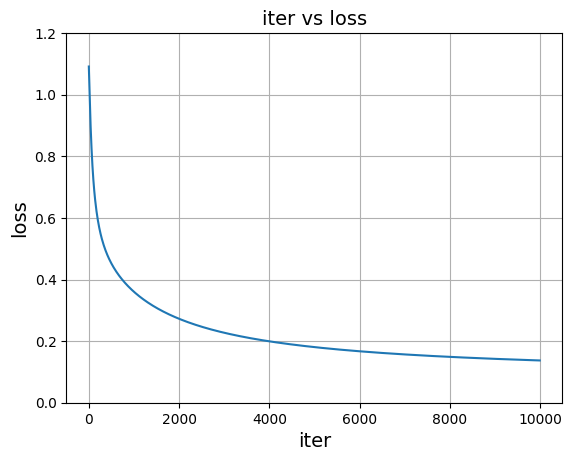

In [111]:
# 학습 곡선 표시 (손실 함수)
plt.plot(history[:,0], history[:,1])
plt.ylim(0,1.2)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

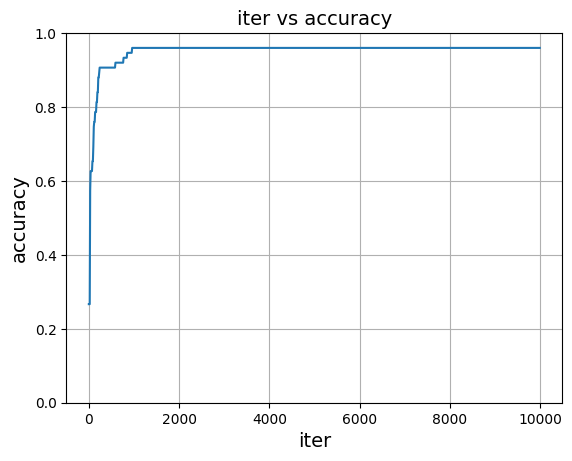

In [112]:
# 학습 곡선 표시 (정밀도)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

In [113]:
# 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 테스트 데이터로 예측값 계산
yp_test_one = pred(x_test, W)
yp_test = np.argmax(yp_test_one, axis=1)

# 정확도 계산
score = accuracy_score(y_test, yp_test)
print(f'accuracy: {score}')

# 컨퓨전 매트릭스의 표시
print(confusion_matrix(y_test, yp_test))
print(classification_report(y_test, yp_test))

accuracy: 0.96
[[27  0  0]
 [ 0 20  0]
 [ 0  3 25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.87      1.00      0.93        20
           2       1.00      0.89      0.94        28

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.97      0.96      0.96        75

